# ** Fruit 360 **

We'll work with the [Fruit 360 dataset](https://www.kaggle.com/datasets/moltean/fruits) from Kaggle.

This is image data of fruits and vegetables. It contains around 90k images of size 100x100 distributed under 131 categories.
The Train and Test data is separated. There are around 68k images in Train and 23k in Test.

In [1]:
import os
import pathlib

from tqdm import tqdm
import cv2

import numpy as np
from numpy.random import randint, randn
from sklearn.utils import shuffle
from matplotlib import pyplot as plt


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, ReLU, LeakyReLU, Activation, MaxPool2D, Flatten, Dense
from keras.layers import Conv2DTranspose, Reshape, GaussianNoise
from keras import optimizers as o
from keras import regularizers as r
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set the random seed
tf.random.set_seed(42)

# Import and preprocess the data

## Import the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! unzip "/content/drive/MyDrive/Machine Learning Datasets and Saved Models/Fruits 360/Fruits 360 - 20 classes".zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: Training/Pomegranate/316_100.jpg  
  inflating: Training/Pomegranate/317_100.jpg  
  inflating: Training/Pomegranate/318_100.jpg  
  inflating: Training/Pomegranate/319_100.jpg  
  inflating: Training/Pomegranate/31_100.jpg  
  inflating: Training/Pomegranate/320_100.jpg  
  inflating: Training/Pomegranate/r_0_100.jpg  
  inflating: Training/Pomegranate/r_100_100.jpg  
  inflating: Training/Pomegranate/r_101_100.jpg  
  inflating: Training/Pomegranate/r_102_100.jpg  
  inflating: Training/Pomegranate/r_103_100.jpg  
  inflating: Training/Pomegranate/r_104_100.jpg  
  inflating: Training/Pomegranate/r_105_100.jpg  
  inflating: Training/Pomegranate/r_106_100.jpg  
  inflating: Training/Pomegranate/r_107_100.jpg  
  inflating: Training/Pomegranate/r_108_100.jpg  
  inflating: Training/Pomegranate/r_109_100.jpg  
  inflating: Training/Pomegranate/r_110_100.jpg  
  inflating: Training/Pomegranate/r_111_100.jpg  
  inflatin

> 🔑 **Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cell above.

## Overview the data

In [5]:
!ls

drive  sample_data  Test  Training


In [6]:
!ls "Training"

'Apple Granny Smith'   Blueberry	   Guava       Orange	   Pomegranate
'Apple Red 1'	      'Cherry Wax Black'   Kiwi        Peach	   Quince
 Apricot	      'Grapefruit Pink'    Mandarine   Pear	   Strawberry
 Banana		      'Grape White'	   Mango       Pineapple   Watermelon


In [7]:
train_dir = "Training"
test_dir = "Test"

In [8]:
# Walk through train directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 20 directories and 0 images in 'Training'.
There are 0 directories and 492 images in 'Training/Apricot'.
There are 0 directories and 490 images in 'Training/Grapefruit Pink'.
There are 0 directories and 492 images in 'Training/Apple Red 1'.
There are 0 directories and 479 images in 'Training/Orange'.
There are 0 directories and 490 images in 'Training/Mango'.
There are 0 directories and 466 images in 'Training/Kiwi'.
There are 0 directories and 492 images in 'Training/Cherry Wax Black'.
There are 0 directories and 490 images in 'Training/Mandarine'.
There are 0 directories and 490 images in 'Training/Guava'.
There are 0 directories and 492 images in 'Training/Pomegranate'.
There are 0 directories and 490 images in 'Training/Pineapple'.
There are 0 directories and 490 images in 'Training/Grape White'.
There are 0 directories and 490 images in 'Training/Quince'.
There are 0 directories and 475 images in 'Training/Watermelon'.
There are 0 directories and 492 images in 'Training/

In [9]:
# Another way to find out how many images are in a file
num_specific_class_train = len(os.listdir(train_dir))
num_specific_class_train

20

In [10]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Apple Granny Smith' 'Apple Red 1' 'Apricot' 'Banana' 'Blueberry'
 'Cherry Wax Black' 'Grape White' 'Grapefruit Pink' 'Guava' 'Kiwi'
 'Mandarine' 'Mango' 'Orange' 'Peach' 'Pear' 'Pineapple' 'Pomegranate'
 'Quince' 'Strawberry' 'Watermelon']


In [11]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (96, 96)
INPUT_TENSOR = (96, 96, 3)

## Load the data

In [12]:
def load_data():
    """
        Load the data:
            - 9,738 images to train the network.
            - 3,267 images to test how accurately the network learned to classify images.
    """
    
    datasets = [train_dir, test_dir]
    output = []

    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   

        images = (images - 127.5)/ 127.5
        
        output.append((images, labels))

    return output

In [13]:
(train_data, train_labels), (test_data, test_labels) = load_data()

Loading Training


100%|██████████| 490/490 [00:00<00:00, 3962.54it/s]


Loading Test


100%|██████████| 166/166 [00:00<00:00, 3290.33it/s]


In [14]:
tf.random.set_seed(42)
train_data, train_labels = shuffle(train_data, train_labels, random_state=427)

# Complete GAN

## Discriminator

In [15]:
# Build the model
discriminator_A1 = Sequential([
  Conv2D(16, 3, input_shape=(INPUT_TENSOR), padding='same'),
  Activation('relu'),
  MaxPool2D(), 
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(), # flatten
  Dense(20), # number of neurons same as number of classes
  Activation('softmax')
])

discriminator_A1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 activation (Activation)     (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                    

In [16]:
# Onehot encoding
train_labels = np_utils.to_categorical(train_labels, 20)
test_labels = np_utils.to_categorical(test_labels, 20)

# Compilation
discriminator_A1.compile(loss='categorical_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

# Evaluation
discriminator_A1.fit(train_data, train_labels, epochs=6, shuffle=True, validation_data=(test_data, test_labels), batch_size=128)

Epoch 1/6
77/77 [==============================] - 12s 34ms/step - loss: 0.3848 - accuracy: 0.9033 - val_loss: 0.0910 - val_accuracy: 0.9565
Epoch 2/6
77/77 [==============================] - 2s 22ms/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.0584 - val_accuracy: 0.9688
Epoch 3/6
77/77 [==============================] - 2s 22ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 0.9737
Epoch 4/6
77/77 [==============================] - 2s 22ms/step - loss: 5.7217e-04 - accuracy: 1.0000 - val_loss: 0.0521 - val_accuracy: 0.9743
Epoch 5/6
77/77 [==============================] - 2s 24ms/step - loss: 3.3416e-04 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9734
Epoch 6/6
77/77 [==============================] - 2s 30ms/step - loss: 2.3507e-04 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9737


## Generator

In [17]:
# define the number of nodes and latent dimension in the Input layer
n_nodes = 256 * 12 * 12
latent_dim = 1

generator_A = Sequential([
  Dense(n_nodes, input_dim = latent_dim),
  LeakyReLU(alpha=0.2),
  Reshape((12, 12, 256)),
  # upsample to 24x24
  Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  # upsample to 48x48
  Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  # upsample to 96x96
  Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),
  # output
  Dense(3, activation='tanh'),
  Reshape(INPUT_TENSOR)
])

generator_A.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 36864)             73728     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36864)             0         
                                                                 
 reshape (Reshape)           (None, 12, 12, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 24, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 48, 128)      262272    
 ranspose)                                            

In [18]:
# Compilation
generator_A.compile(loss='mean_squared_error', 
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

## Building GAN

In [19]:
discriminator_A1.trainable = False

gan_A = Sequential([
  generator_A,
  discriminator_A1
])

gan_A.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 96, 96, 3)         1123075   
                                                                 
 sequential (Sequential)     (None, 20)                373748    
                                                                 
Total params: 1,496,823
Trainable params: 1,123,075
Non-trainable params: 373,748
_________________________________________________________________


In [20]:
gan_A.compile(loss='categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(),
            metrics='accuracy')

In [21]:
def generate_latent_points(latent_dim):
  x = randn(latent_dim)
  x = x.reshape(1,latent_dim)
  return x

## Results

In [25]:
classes = np.array(range(20))
generated_images = []

images = train_data[15:(15+1)]
for image in images:
  for target in classes:
    if target != np.argmax(train_labels[15]):
      target_class = np.zeros((1,20))
      target_class[0][target] = 1
      latent_points = generate_latent_points(latent_dim)
      for _ in tqdm(range(100)):
        generator_A.train_on_batch(latent_points, image.reshape(1,96,96,3))
        gan_A.train_on_batch(latent_points, target_class)
      generated_images.append(generator_A.predict(latent_points))

100%|██████████| 100/100 [00:02<00:00, 40.77it/s]


1/1 [==============================] - 0s 21ms/step


100%|██████████| 100/100 [00:02<00:00, 41.35it/s]

1/1 [==============================] - 0s 21ms/step



100%|██████████| 100/100 [00:02<00:00, 40.78it/s]

1/1 [==============================] - 0s 21ms/step



100%|██████████| 100/100 [00:02<00:00, 40.25it/s]

1/1 [==============================] - 0s 28ms/step



100%|██████████| 100/100 [00:03<00:00, 25.54it/s]


1/1 [==============================] - 0s 105ms/step


100%|██████████| 100/100 [00:06<00:00, 14.74it/s]

1/1 [==============================] - 0s 28ms/step



100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


1/1 [==============================] - 0s 111ms/step


100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


1/1 [==============================] - 0s 21ms/step


100%|██████████| 100/100 [00:02<00:00, 42.43it/s]

1/1 [==============================] - 0s 21ms/step



100%|██████████| 100/100 [00:02<00:00, 42.33it/s]


1/1 [==============================] - 0s 25ms/step


100%|██████████| 100/100 [00:02<00:00, 38.97it/s]


1/1 [==============================] - 0s 33ms/step


100%|██████████| 100/100 [00:03<00:00, 32.12it/s]


1/1 [==============================] - 0s 22ms/step


100%|██████████| 100/100 [00:02<00:00, 41.13it/s]

1/1 [==============================] - 0s 19ms/step



100%|██████████| 100/100 [00:02<00:00, 42.94it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 41.71it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 41.37it/s]


1/1 [==============================] - 0s 32ms/step


100%|██████████| 100/100 [00:03<00:00, 32.35it/s]


1/1 [==============================] - 0s 21ms/step


100%|██████████| 100/100 [00:02<00:00, 42.65it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 43.64it/s]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


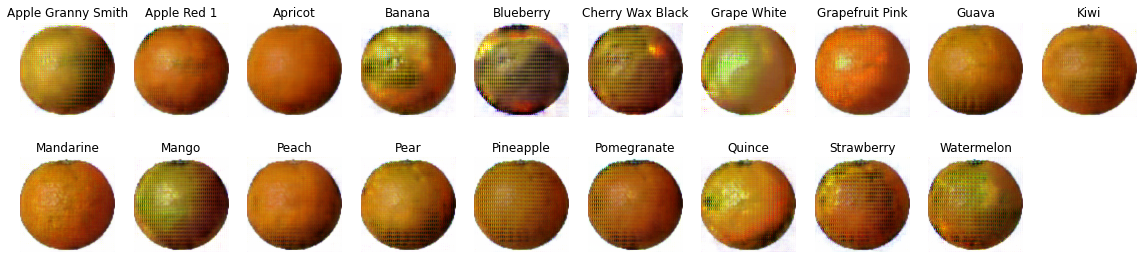

In [30]:
plt.figure(figsize=(20,7))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, int(len(classes)/2), i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape(INPUT_TENSOR))
  plt.title(class_names[np.argmax(discriminator_A1.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

In [31]:
classes = np.array(range(20))
generated_images = []

images = train_data[28:(28+1)]
for image in images:
  for target in classes:
    if target != np.argmax(train_labels[28]):
      target_class = np.zeros((1,20))
      target_class[0][target] = 1
      latent_points = generate_latent_points(latent_dim)
      for _ in tqdm(range(100)):
        generator_A.train_on_batch(latent_points, image.reshape(1,96,96,3))
        gan_A.train_on_batch(latent_points, target_class)
      generated_images.append(generator_A.predict(latent_points))

100%|██████████| 100/100 [00:02<00:00, 34.02it/s]


1/1 [==============================] - 0s 80ms/step


100%|██████████| 100/100 [00:05<00:00, 19.63it/s]

1/1 [==============================] - 0s 34ms/step



100%|██████████| 100/100 [00:02<00:00, 40.65it/s]

1/1 [==============================] - 0s 24ms/step



100%|██████████| 100/100 [00:02<00:00, 37.63it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


1/1 [==============================] - 0s 101ms/step


100%|██████████| 100/100 [00:03<00:00, 32.62it/s]


1/1 [==============================] - 0s 34ms/step


100%|██████████| 100/100 [00:02<00:00, 35.25it/s]


1/1 [==============================] - 0s 32ms/step


100%|██████████| 100/100 [00:02<00:00, 35.96it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:04<00:00, 20.06it/s]

1/1 [==============================] - 0s 32ms/step



100%|██████████| 100/100 [00:02<00:00, 35.43it/s]


1/1 [==============================] - 0s 21ms/step


100%|██████████| 100/100 [00:02<00:00, 41.59it/s]


1/1 [==============================] - 0s 22ms/step


100%|██████████| 100/100 [00:02<00:00, 41.68it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 40.26it/s]


1/1 [==============================] - 0s 33ms/step


100%|██████████| 100/100 [00:03<00:00, 31.52it/s]

1/1 [==============================] - 0s 21ms/step



100%|██████████| 100/100 [00:02<00:00, 41.03it/s]

1/1 [==============================] - 0s 22ms/step



100%|██████████| 100/100 [00:02<00:00, 41.43it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 43.32it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 39.92it/s]

1/1 [==============================] - 0s 29ms/step



100%|██████████| 100/100 [00:03<00:00, 32.12it/s]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


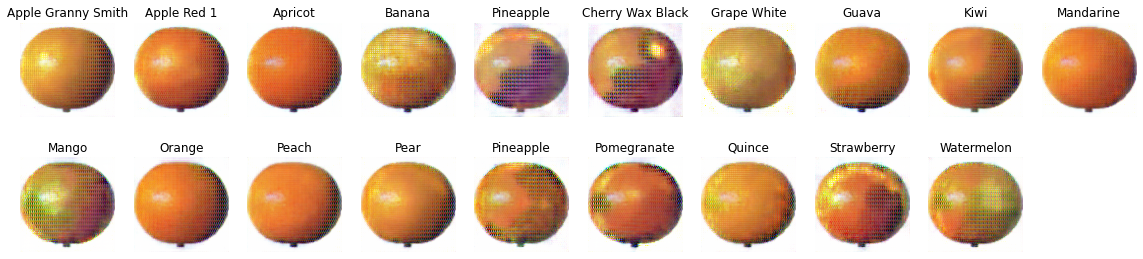

In [32]:
plt.figure(figsize=(20,7))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, int(len(classes)/2), i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape(INPUT_TENSOR))
  plt.title(class_names[np.argmax(discriminator_A1.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

In [39]:
classes = np.array(range(20))
generated_images = []

images = train_data[37:(37+1)]
for image in images:
  for target in classes:
    if target != np.argmax(train_labels[37]):
      target_class = np.zeros((1,20))
      target_class[0][target] = 1
      latent_points = generate_latent_points(latent_dim)
      for _ in tqdm(range(100)):
        generator_A.train_on_batch(latent_points, image.reshape(1,96,96,3))
        gan_A.train_on_batch(latent_points, target_class)
      generated_images.append(generator_A.predict(latent_points))

100%|██████████| 100/100 [00:02<00:00, 33.46it/s]

1/1 [==============================] - 0s 21ms/step



100%|██████████| 100/100 [00:02<00:00, 41.45it/s]

1/1 [==============================] - 0s 22ms/step



100%|██████████| 100/100 [00:02<00:00, 41.65it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 42.11it/s]

1/1 [==============================] - 0s 27ms/step



100%|██████████| 100/100 [00:02<00:00, 36.82it/s]


1/1 [==============================] - 0s 30ms/step


100%|██████████| 100/100 [00:02<00:00, 34.10it/s]

1/1 [==============================] - 0s 19ms/step



100%|██████████| 100/100 [00:02<00:00, 41.83it/s]


1/1 [==============================] - 0s 20ms/step


100%|██████████| 100/100 [00:02<00:00, 42.64it/s]

1/1 [==============================] - 0s 22ms/step



100%|██████████| 100/100 [00:02<00:00, 42.35it/s]

1/1 [==============================] - 0s 25ms/step



100%|██████████| 100/100 [00:02<00:00, 34.81it/s]

1/1 [==============================] - 0s 31ms/step



100%|██████████| 100/100 [00:02<00:00, 34.70it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 43.11it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 42.33it/s]

1/1 [==============================] - 0s 22ms/step



100%|██████████| 100/100 [00:02<00:00, 42.07it/s]

1/1 [==============================] - 0s 21ms/step



100%|██████████| 100/100 [00:02<00:00, 37.29it/s]

1/1 [==============================] - 0s 32ms/step



100%|██████████| 100/100 [00:02<00:00, 34.55it/s]

1/1 [==============================] - 0s 21ms/step



100%|██████████| 100/100 [00:02<00:00, 41.43it/s]

1/1 [==============================] - 0s 20ms/step



100%|██████████| 100/100 [00:02<00:00, 41.63it/s]

1/1 [==============================] - 0s 22ms/step



100%|██████████| 100/100 [00:02<00:00, 41.91it/s]

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 34ms/step


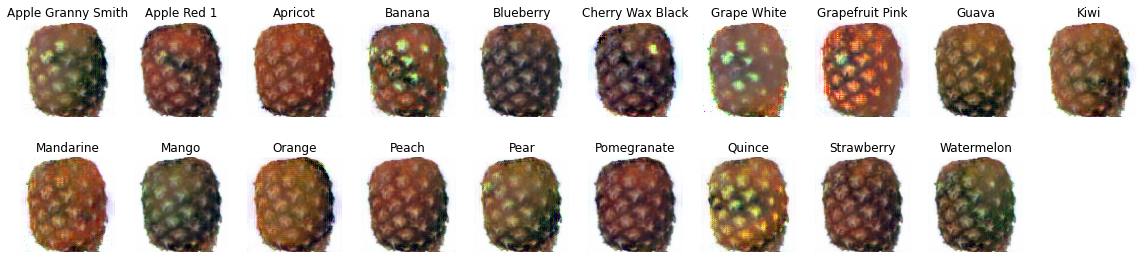

In [40]:
plt.figure(figsize=(20,7))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, int(len(classes)/2), i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape(INPUT_TENSOR))
  plt.title(class_names[np.argmax(discriminator_A1.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

# Deeper Discriminator

In [41]:
# Build the model
discriminator_A2 = Sequential([
  Conv2D(16, 3, input_shape=INPUT_TENSOR, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  Activation('relu'),
  MaxPool2D(),
  Flatten(),
  Dense(120),
  Activation('relu'),
  Dense(20), # number of neurons same as number of classes
  Activation('softmax')
])

discriminator_A2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 activation_8 (Activation)   (None, 96, 96, 16)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 activation_9 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

In [42]:
# Compilation
discriminator_A2.compile(loss='categorical_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

# Evaluation
discriminator_A2.fit(train_data, train_labels, epochs=6, shuffle=True, validation_data=(test_data, test_labels), batch_size=128)

Epoch 1/6
77/77 [==============================] - 4s 36ms/step - loss: 0.5083 - accuracy: 0.8549 - val_loss: 0.1060 - val_accuracy: 0.9611
Epoch 2/6
77/77 [==============================] - 2s 26ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.0469 - val_accuracy: 0.9829
Epoch 3/6
77/77 [==============================] - 2s 26ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0283 - val_accuracy: 0.9862
Epoch 4/6
77/77 [==============================] - 2s 28ms/step - loss: 4.9204e-04 - accuracy: 1.0000 - val_loss: 0.0334 - val_accuracy: 0.9865
Epoch 5/6
77/77 [==============================] - 2s 31ms/step - loss: 0.0179 - accuracy: 0.9935 - val_loss: 0.1048 - val_accuracy: 0.9773
Epoch 6/6
77/77 [==============================] - 2s 26ms/step - loss: 2.4579e-04 - accuracy: 1.0000 - val_loss: 0.0883 - val_accuracy: 0.9703


1/1 [==============================] - 0s 19ms/step


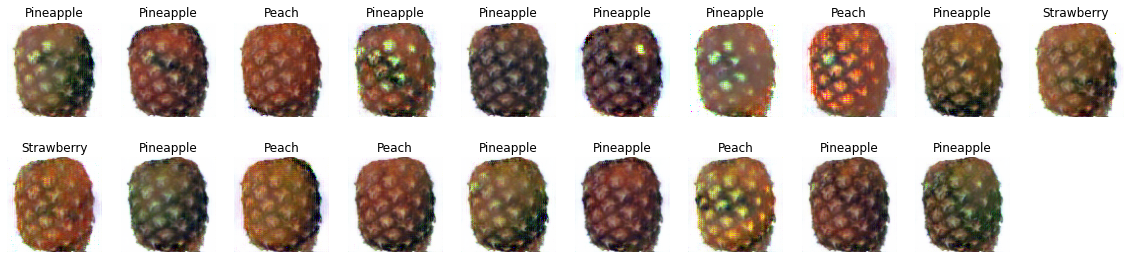

In [43]:
plt.figure(figsize=(20,7))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, int(len(classes)/2), i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape(INPUT_TENSOR))
  plt.title(class_names[np.argmax(discriminator_A2.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images_A2.png' 
plt.savefig(filename)
plt.show()